## 빈도분석

In [1]:
import pandas as pd

In [2]:
file = "./data/un-general-debates-blueprint.csv"
df = pd.read_csv(file)

In [3]:
df.sample(5)

,session,year,country,country_name,speaker,position,text
7153,69,2014,CIV,Côte d'Ivoire,Alassane Ouattara,President,Like the \nother Heads of State and Government...
2791,45,1990,GTM,Guatemala,Rivera Irias,NaN,"Sir, on behalf of the delegation of Guatemala,..."
1555,37,1982,BLR,Belarus,GURINOVICH,NaN,"Mr. President, please accept my warm congratul..."
786,31,1976,PNG,Papua New Guinea,Sir Maori Kiki,NaN,At the outset I wish to congratulate Mr. Amera...
1442,36,1981,FJI,Fiji,Mr. BOLE,NaN,My delegation joins with others who have spoke...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7507 non-null   int64 
 1   year          7507 non-null   int64 
 2   country       7507 non-null   object
 3   country_name  7507 non-null   object
 4   speaker       7480 non-null   object
 5   position      4502 non-null   object
 6   text          7507 non-null   object
dtypes: int64(2), object(5)
memory usage: 410.7+ KB


In [5]:
df[['country','speaker']].describe().T

,count,unique,top,freq
country,7507,199,ALB,46
speaker,7480,5428,Seyoum Mesfin,12


In [6]:
df.isna().sum(axis=0)

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
dtype: int64

In [7]:
df['length'] = df['text'].map(len)

<Axes: >

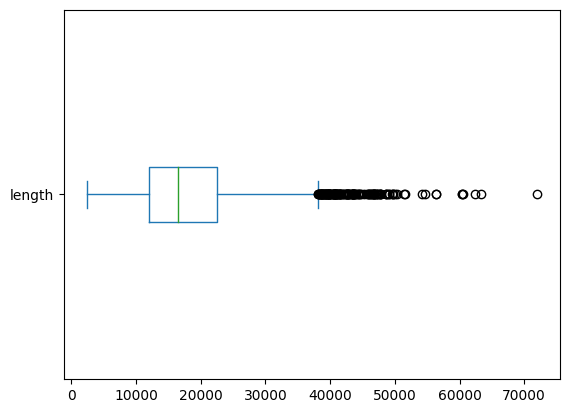

In [8]:
df['length'].plot(kind='box', vert=False)

<Axes: ylabel='Frequency'>

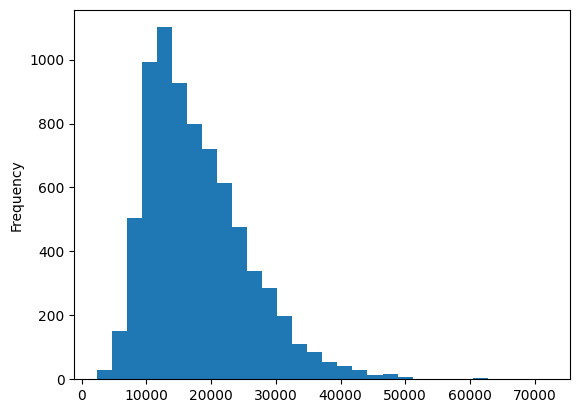

In [9]:
df['length'].plot(kind='hist', bins=30)

In [10]:
import seaborn as sns

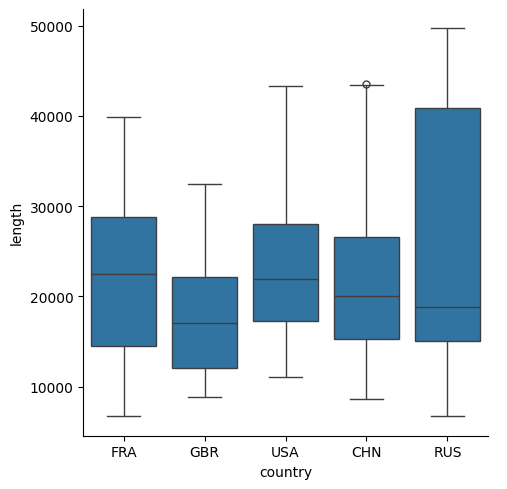

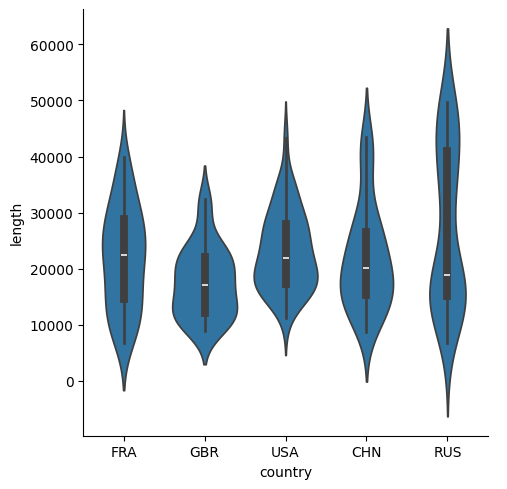

In [11]:
where = df['country'].isin(['USA','FRA','GBR','CHN','RUS'])
sns.catplot(data=df.loc[where], x='country', y='length', kind='box')
sns.catplot(data=df.loc[where], x='country', y='length', kind='violin')

<Axes: title={'center': 'Number of Countries'}, xlabel='year'>

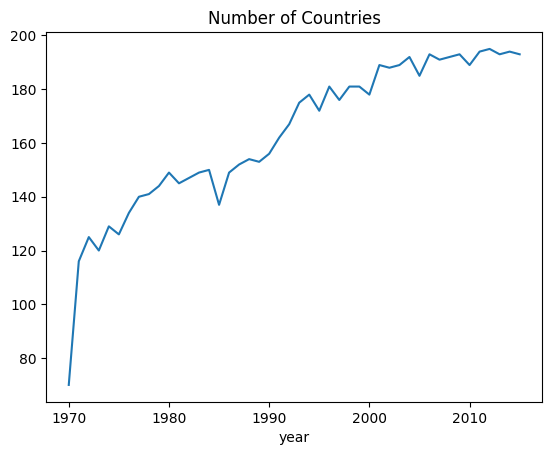

In [12]:
df.groupby('year').size().plot(title='Number of Countries')

<Axes: title={'center': 'Average speech length'}, xlabel='year'>

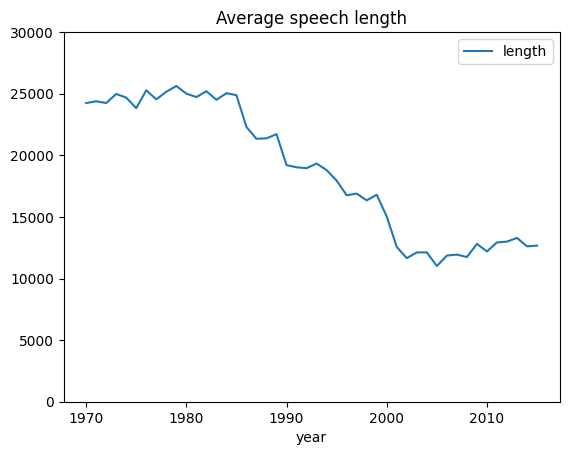

In [13]:
df.groupby('year').agg({'length': 'mean'}).plot(title='Average speech length', ylim=(0,30000))

정규표현식을 이용한 토큰화

In [14]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [15]:
text = "Let's defeat SARS_CoV-2 together in 2020!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS_CoV-2|together|in


In [16]:
text = "2024년에는 전쟁없는 평화로운 세상이 올까?"
tokens = tokenize(text)
print("|".join(tokens))

2024년에는|전쟁없는|평화로운|세상이|올까


불용어 제거

In [17]:
import nltk

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\inwo9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
stopwords = set(nltk.corpus.stopwords.words('english'))
len(stopwords)

179

In [20]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [21]:
include_stopwords = {'dear', 'regrads', 'must', 'would', 'also'}
exclude_stopwords = {'against'}
stopwords |= include_stopwords
stopwords -= exclude_stopwords

In [22]:
len(stopwords)

183

In [23]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [24]:
prepare(text, pipeline)

['2024년에는', '전쟁없는', '평화로운', '세상이', '올까']

In [25]:
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)

In [26]:
from collections import Counter

tokens = tokenize("She likes my cats and my cats likes my sofa")

counter = Counter(tokens)
print(counter)

Counter({'my': 3, 'likes': 2, 'cats': 2, 'She': 1, 'and': 1, 'sofa': 1})


In [27]:
counter.update(tokenize("cats are adorable"))
print(counter)

Counter({'my': 3, 'cats': 3, 'likes': 2, 'She': 1, 'and': 1, 'sofa': 1, 'are': 1, 'adorable': 1})


In [28]:
counter.most_common(5)

[('my', 3), ('cats', 3), ('likes', 2), ('She', 1), ('and', 1)]

In [29]:
def count_words(df, column='tokens', preprocess=None, min_freq=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    counter=Counter()
    df[column].map(update)

    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [30]:
freq_df = count_words(df)
freq_df.head(5)

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [31]:
count_words(df, column='text', preprocess=lambda text: re.findall(r"\w{10,}", text))

,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177
...,...
enfranchising,2
interrelate,2
compositions,2


[Text(0.5, 0, 'Freq'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top words')]

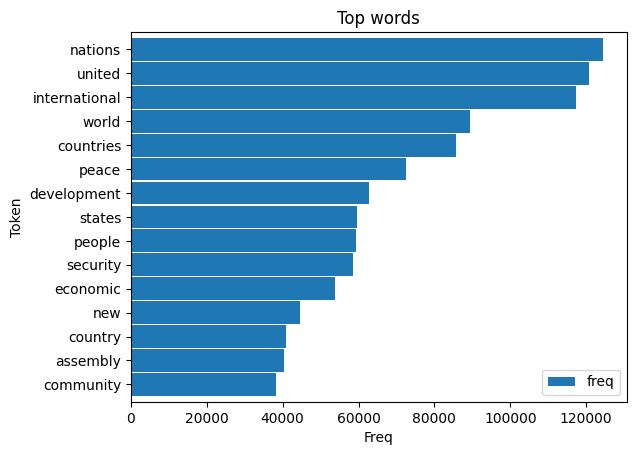

In [32]:
ax = freq_df.head(15).plot(kind="barh", width=0.95)
ax.invert_yaxis()
ax.set(xlabel="Freq", ylabel="Token", title="Top words")

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [34]:
text = df.query("year==2015 and country=='USA'")['text'].values[0]

(-0.5, 399.5, 199.5, -0.5)

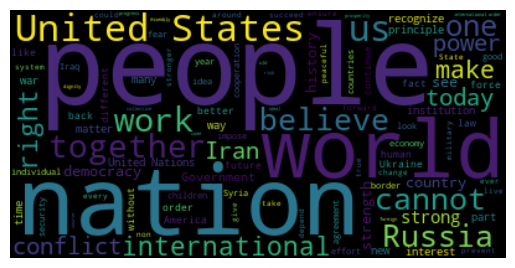

In [35]:
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

In [36]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400, background_color="black", colormap="Paired", max_font_size=150, max_words=max_words)

    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    if stopwords is not None:
        counter = {token: freq for (token, freq) in counter.items() if token not in stopwords}

    wc.generate_from_frequencies(counter)

    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')

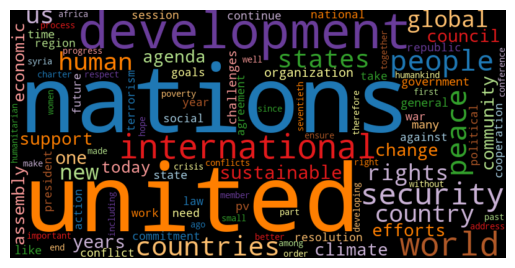

In [37]:
freq_2015_df = count_words(df[df['year']==2015])
plt.figure()
wordcloud(freq_2015_df['freq'], max_words=100)

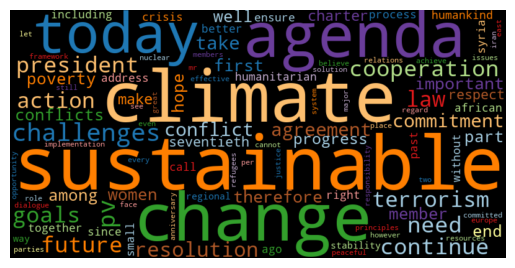

In [38]:
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)

In [39]:
import numpy as np

In [40]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    counter = Counter()
    df[column].map(update)

    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df']) + 0.1
    idf_df.index.name = 'token'
    return idf_df

In [41]:
idf_df = compute_idf(df)

C:\Users\inwo9\AppData\Local\Temp\ipykernel_12380\49995720.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df']) + 0.1


In [42]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

In [43]:
freq_df

,freq,tfidf
token,,
nations,124508,12649.986284
united,120763,12285.608632
international,117223,12364.276226
world,89421,9503.708982
countries,85734,10888.485986
...,...,...
over-used,2,16.660888
culled,2,16.660888
twelve-power,2,NaN


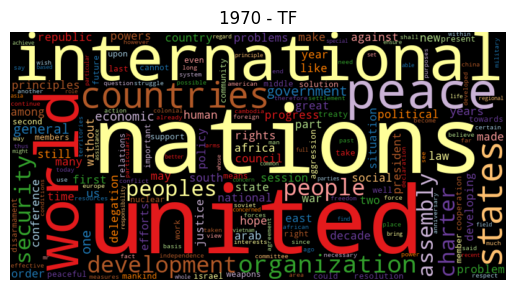

In [44]:
freq_1970 = count_words(df[df['year']==1970])
freq_2015 = count_words(df[df['year']==2015])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

wordcloud(freq_1970['freq'], title='1970 - TF', stopwords=['twenty-fifth', 'twenty-five'])

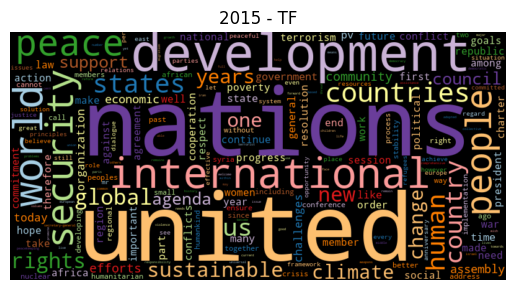

In [45]:
wordcloud(freq_2015['freq'], title='2015 - TF', stopwords=['seventieth'])

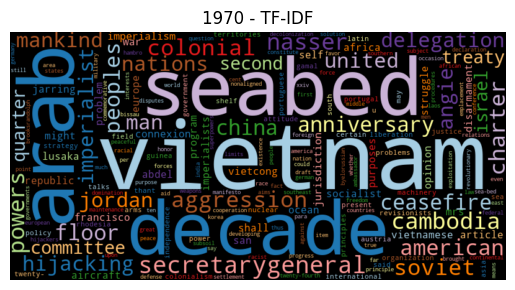

In [46]:
wordcloud(freq_1970['tfidf'], title='1970 - TF-IDF', stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])

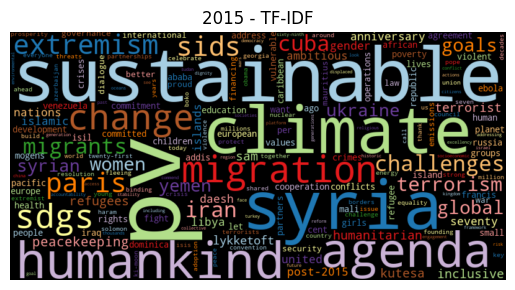

In [47]:
wordcloud(freq_2015['tfidf'], title='2015 - TF-IDF', stopwords=['seventieth'])

## 컨텍스트 내 키워드 탐색

In [48]:
from textacy.extract import keyword_in_context

In [49]:
import random

In [50]:
def kwic(doc_series, keyword, window=35, print_samples=5):
    def add_kwic(text):
        kwic_list.extend(keyword_in_context(text, keyword, ignore_case=True, window_width=window))

    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0]) + ' ' + sample[1] + ' ' + re.sub(r'[\n\t]', ' ', sample[2]))
                

In [51]:
kwic(df[df['year']==2015]['text'], 'sdgs', print_samples=5)

5 random samples out of 73 contexts for 'sdgs':
iven the ambition reflected in the  SDGs , we surely will need to scale up t
 population in accordance with the  SDGs . The leaders of the Pacific small 
its Sustainable Development Goals ( SDGs ) (resolution 70/1), which can be c
the Sustainable Development Goals ( SDGs ) will be an effective tool in glob
ction. That can happen only if the  SDGs  are matched with the necessary res


## N-gram 분석

In [53]:
def ngrams(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [54]:
text = "the visible manifestation of the global climate change"
tokens = tokenize(text)
print(tokens)
print("|".join(ngrams(tokens, 2)))

['the', 'visible', 'manifestation', 'of', 'the', 'global', 'climate', 'change']
the visible|visible manifestation|manifestation of|of the|the global|global climate|climate change


In [58]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
           if len([t for t in ngram if t in stopwords]) == 0]

In [59]:
print("Bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))

Bigrams: visible manifestation|global climate|climate change


In [60]:
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

Trigrams: global climate change


In [61]:
df['bigrams'] = df['text'].apply(prepare, pipeline=[str.lower, tokenize]).apply(ngrams, n=2, stopwords=stopwords)

count_words(df, 'bigrams').head(5)

,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856


C:\Users\inwo9\AppData\Local\Temp\ipykernel_12380\49995720.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df']) + 0.1


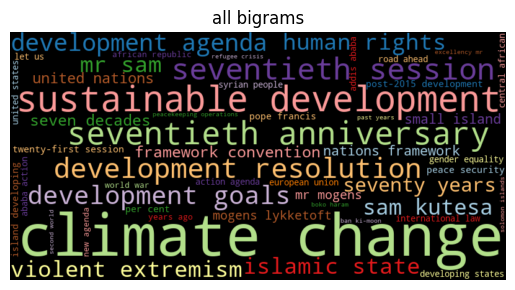

In [62]:
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['year']==2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']
wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

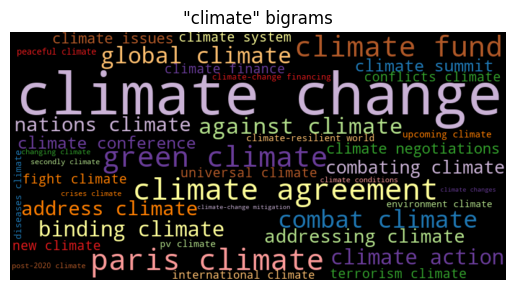

In [69]:
where = freq_df.index.str.contains('climate')
wordcloud(freq_df[where]['freq'], title='"climate" bigrams', max_words=50)

## 시간 및 범주에 따른 빈도 비교

In [70]:
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [72]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'climate', 'climate', 'freedom', 'climate', 'freedom']

print(count_keywords(tokens, keywords))

[1, 0, 3, 2]


In [73]:
def count_keywords_by(df, by, keywords, column='tokens'):
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by]

    return freq_df.groupby(by=by).sum().sort_values(by)

In [74]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)

<Axes: xlabel='year'>

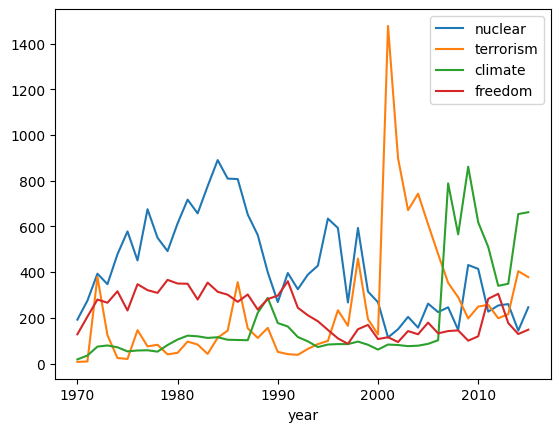

In [76]:
freq_df.plot(kind='line')

In [78]:
import seaborn as sns

<Axes: xlabel='year'>

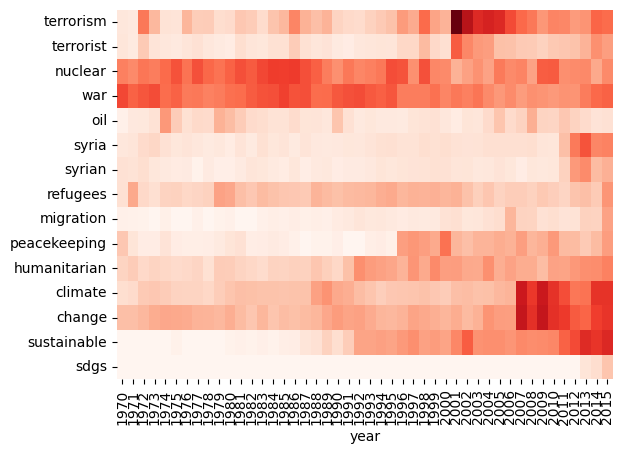

In [82]:
keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil', 'syria', 'syrian', 'refugees', 'migration', 'peacekeeping', 'humanitarian', 'climate', 'change', 'sustainable', 'sdgs']

freq_df = count_keywords_by(df, by='year', keywords=keywords)

# 상대빈도 계산
df['num_tokens'] = df['tokens'].apply(len)
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)
freq_df = freq_df.apply(np.sqrt)

sns.heatmap(data=freq_df.T, xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")